# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import tensorflow.keras.layers as tfl
import gc

2025-04-19 11:29:48.795321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745062188.997780     246 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745062189.054403     246 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Preparing GPU

In [2]:
# Preparing GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ Using GPU")
    strategy = tf.distribute.MirroredStrategy()
else:
    print("❌ Using CPU")
    strategy = tf.distribute.get_strategy()

✅ Using GPU


I0000 00:00:1745062196.204605     246 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745062196.206028     246 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Loading Data

In [3]:
from tensorflow.keras.datasets import cifar100
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='coarse')

###  Shape Of Data 

In [4]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


# Resizing images

In [5]:
import cv2
IMG_SIZE = (160, 160)


In [6]:
X_train = np.array([cv2.resize(img, IMG_SIZE) for img in X_train])


In [7]:
X_test = np.array([cv2.resize(img, IMG_SIZE) for img in X_test])


# Encoding labels

In [8]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train).toarray().astype(int)
y_test = enc.transform(y_test).toarray().astype(int)

print("✅ Data loaded and processed:", X_train.shape, y_train.shape)


✅ Data loaded and processed: (50000, 160, 160, 3) (50000, 20)


# Preparing mobileNet_V2's Preprocessing

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


# Modle Definitions

In [10]:
def transfer_from_MN(image_shape=IMG_SIZE):
    base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape + (3,), include_top=False, weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=image_shape + (3,))
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.2)(x)
    outputs = tfl.Dense(units=20, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

###  MobileNetV2 + Dense Layers


In [11]:
def transfer_from_MN_2(image_shape=IMG_SIZE):
    base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape + (3,), include_top=False, weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=image_shape + (3,))
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.2)(x)
    for _ in range(4):
        x = tfl.Dense(100)(x)
        x = tfl.LeakyReLU()(x)
        x = tfl.Dropout(0.2)(x)
    outputs = tfl.Dense(units=20, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)


### EfficientNetB0 Model


In [12]:
def efficientnet_model(image_shape=IMG_SIZE):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=image_shape + (3,), include_top=False, weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=image_shape + (3,))
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.3)(x)
    outputs = tfl.Dense(units=20, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

### Training Models


In [13]:
initial_epochs = 10
BATCH_SIZE = 8


In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE * strategy.num_replicas_in_sync)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE * strategy.num_replicas_in_sync)


In [15]:
with strategy.scope():
    model = transfer_from_MN()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_dataset, validation_data=test_dataset, epochs=initial_epochs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


I0000 00:00:1745062237.285301     309 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745062237.285983     306 cuda_dnn.cc:529] Loaded cuDNN version 90300


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.5719 - loss: 1.4245 - val_accuracy: 0.7080 - val_loss: 0.9249
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.7029 - loss: 0.9735 - val_accuracy: 0.7202 - val_loss: 0.9043
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.7151 - loss: 0.9313 - val_accuracy: 0.7222 - val_loss: 0.9123
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.7155 - loss: 0.9294 - val_accuracy: 0.7198 - val_loss: 0.9106
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.7216 - loss: 0.9140 - val_accuracy: 0.7254 - val_loss: 0.9200
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.7170 - loss: 0.9211 - val_accuracy: 0.7266 - val_loss: 0.9098
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.7233 - loss: 0.9085 - val_accuracy: 0.7218 - val_loss: 0.9358
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.7226 - loss: 0.91

### Clean memory after training


In [16]:
tf.keras.backend.clear_session()
gc.collect()

0

### Plot Accuracy


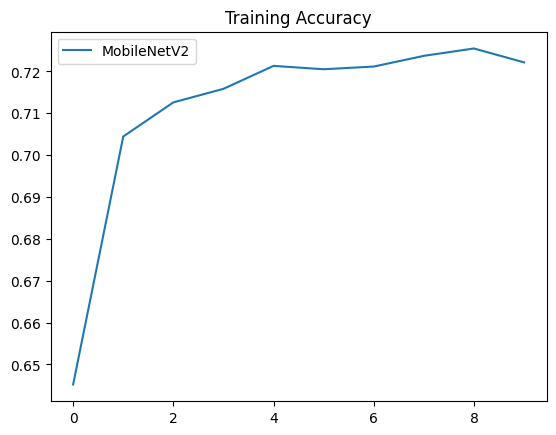

In [17]:
plt.plot(history.history["accuracy"], label="MobileNetV2")
plt.legend()
plt.title("Training Accuracy")
plt.show()


###  Visualization: Accuracy & Loss


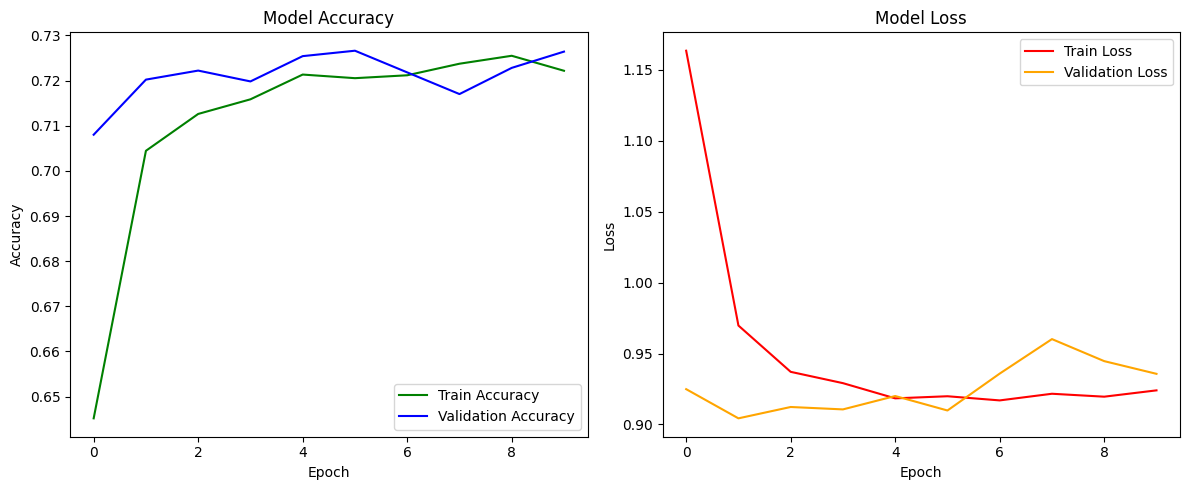

In [23]:

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy", color="green")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss", color="red")
plt.plot(history.history["val_loss"], label="Validation Loss", color="orange")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


### Models Compare 

### Save the model


In [18]:
model.save('/kaggle/working/mobilenetv2_model.h5')
print("✅ Model saved!")

✅ Model saved!


### Zip the model


In [19]:
import zipfile
from IPython.display import FileLink

def zip_dir(directory='/kaggle/working', file_name='model.zip'):
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name not in file:
                zip_ref.write(os.path.join(folder, file))
    return FileLink(file_name)

zip_dir()

/kaggle/working/model.zip